In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random
import cv2 as cv
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.applications import ResNet50
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

In [3]:
data_csv = pd.read_csv("../input/ocular-disease-recognition-odir5k/full_df.csv")

# Building Model 4 - Simple sequential model with multiple layers 

## Defining all the functions 

In [4]:
# to create dataset of the images based on disease
dataset_dir = "../input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size = 224
labels = []
ds = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv.imread(image_path,cv.IMREAD_COLOR)
            image = cv.resize(image,(image_size,image_size))
        except:
            continue
        
        ds.append([np.array(image), np.array(label)])
    random.shuffle(ds)
    return ds

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def show_images():
    plt.figure(figsize=(12,7))
    for i in range(10):
        sample = random.choice(range(len(ds)))
        image = ds[sample][0]
        label = ds[sample][1]
        if label == 0:
            label = "Normal"
        elif label == 1:
            label = "Cataract"
        elif label == 2:
            label = "Diabetes"
        elif label == 3:
            label = "Glaucoma"
        elif label == 4:
            label = "Age-related conditions"
        elif label == 5:
            label = "Hypertension related conditions"
        elif label == 6:
            label = "Myopia"
        elif label == 7:
            label = "Other reasons"
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.xlabel(label)
    plt.tight_layout() 
    
   

In [7]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

In [8]:
# creating a dictionary which stores the disease text string to search, The label it has in data_csv and 
# the label that we are giving for that particular disease
disease_dict = {'cataract': ['C',2], 
                'normal': ['N',1],
                'glaucoma' : ['G', 4],
               'retinopathy':['D',3],
               'age-related': ['A',5],
               'hypertensive' : ['H', 6],
               'myopia' : ['M', 7],
               'other' : ['O', 8]}


# final dictionary to store our file names 
combined_dict = {}

# function to segregate image names based on the fundus disease
def diseased_fundus():
    for disease_name, disease_label in disease_dict.items():
        left_eye_col_name = 'left_' + disease_name 
        right_eye_col_name = 'right_' + disease_name
        # creating a blank column for left and right eye to avoid keyerror
        data_csv[left_eye_col_name] = " "
        data_csv[right_eye_col_name] = " "
        # creating two new columns, one for the left eye and one for the right 
        for index, row in data_csv.iterrows():
            # for rest of the cases 
            if disease_name in data_csv['Left-Diagnostic Keywords'][index]:
                data_csv[left_eye_col_name][index] = disease_label[1]
            else:
                data_csv[left_eye_col_name][index] = 0
            if disease_name in data_csv['Right-Diagnostic Keywords'][index]:
                data_csv[right_eye_col_name][index] = disease_label[1]
            else:
                data_csv[right_eye_col_name][index] = 0
            # seperate case for other retinal diseases (for column where 'O' is 1)
            if disease_name == 'other':
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Left-Diagnostic Keywords'][index]:
                    data_csv[left_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[left_eye_col_name][index] = 0
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Right-Diagnostic Keywords'][index]:
                    data_csv[right_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[right_eye_col_name][index] = 0
        
        # fetching/filtering all the image names where disease exists in the left eye and has value assigned through 
        # our function and using the Left-Fundus column to get the image name 
        left_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[left_eye_col_name] == disease_label[1])]['Left-Fundus'].values
        
        # doing the same for the right eye
        right_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[right_eye_col_name] == disease_label[1])]['Right-Fundus'].values
        # merging both the left and right eye file names which have the disease 
        print(disease_label[1])
        combined = np.concatenate((left_eye_col_name, right_eye_col_name), axis=0)

        combined_dict[disease_name]  = pd.Series(combined)

        

diseased_fundus()

combined_dict

2
1
4
3
5
6
7
8


{'cataract': 0          0_left.jpg
 1         81_left.jpg
 2        103_left.jpg
 3        119_left.jpg
 4        254_left.jpg
             ...      
 589    2243_right.jpg
 590    2246_right.jpg
 591    2247_right.jpg
 592    2248_right.jpg
 593    2282_right.jpg
 Length: 594, dtype: object,
 'normal': 0           1_left.jpg
 1           8_left.jpg
 2          84_left.jpg
 3         191_left.jpg
 4         394_left.jpg
              ...      
 4196    3448_right.jpg
 4197    3450_right.jpg
 4198    3485_right.jpg
 4199    4571_right.jpg
 4200    4637_right.jpg
 Length: 4201, dtype: object,
 'glaucoma': 0         95_left.jpg
 1        153_left.jpg
 2        167_left.jpg
 3        178_left.jpg
 4        247_left.jpg
             ...      
 611    1999_right.jpg
 612    2030_right.jpg
 613    2032_right.jpg
 614    2048_right.jpg
 615    2063_right.jpg
 Length: 616, dtype: object,
 'retinopathy': 0           2_left.jpg
 1           5_left.jpg
 2          11_left.jpg
 3          19_left.j

In [9]:
ds = []
ds = create_dataset(combined_dict['cataract'], 1)
ds = create_dataset(combined_dict['glaucoma'], 3)
ds = create_dataset(combined_dict['normal'], 0)
ds = create_dataset(combined_dict['retinopathy'], 2) # for diabetes
ds = create_dataset(combined_dict['age-related'],4)
ds = create_dataset(combined_dict['hypertensive'],5)
ds = create_dataset(combined_dict['myopia'],6)
ds = create_dataset(combined_dict['other'],7)

100%|██████████| 3115/3115 [00:18<00:00, 167.28it/s]


In [10]:
# validating our dataset
print(len(ds))
# Shape of the new dataset
print(np.shape(ds))

13049
(13049, 2)


## Validating our dataset creation 

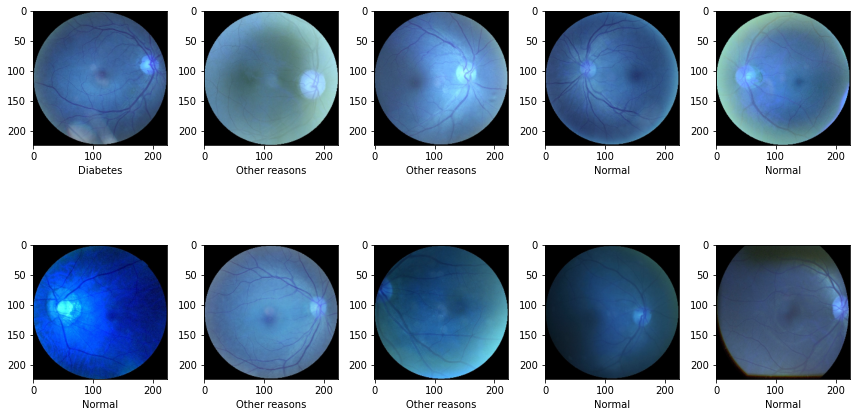

In [11]:
show_images()

## Creating our test and validation set

In [12]:
# Because of the way the labels were created, it's better to categorize them to prevent deceiving the model
X = np.array([i[0] for i in ds]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in ds])
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.5)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(10439, 224, 224, 3)
(1305, 224, 224, 3)
(1305, 224, 224, 3)
(10439, 8)
(1305, 8)
(1305, 8)


## Building our Sequential Model with all the 8 classes

In [13]:
model_4 = Sequential()
model_4.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model_4.add(Flatten())
model_4.add(Dense(units=4096,activation="relu"))
model_4.add(Dense(units=4096,activation="relu"))
model_4.add(Dense(units=8, activation="softmax"))


opt_4 = Adam(lr=0.001)
model_4.compile(optimizer=opt_4, loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

2022-05-01 03:57:03.437234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 03:57:03.537060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 03:57:03.537789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 03:57:03.538915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [14]:
optim_4 = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_4.compile(optimizer= optim_4, loss= 'categorical_crossentropy', metrics=['accuracy'])
training_4 = model_4.fit(x=X_train, y=y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

2022-05-01 03:57:06.617295: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-05-01 03:57:08.344875: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-05-01 03:57:09.509948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-01 03:57:11.157287: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


82/82 [==============================] - 95s 924ms/step - loss: 181.7699 - accuracy: 0.2941 - val_loss: 1.7258 - val_accuracy: 0.3211
Epoch 2/20
82/82 [==============================] - 65s 799ms/step - loss: 1.6946 - accuracy: 0.3171 - val_loss: 1.7116 - val_accuracy: 0.3211
Epoch 3/20
82/82 [==============================] - 66s 799ms/step - loss: 1.6905 - accuracy: 0.3171 - val_loss: 1.7102 - val_accuracy: 0.3211
Epoch 4/20
82/82 [==============================] - 65s 798ms/step - loss: 1.6912 - accuracy: 0.3171 - val_loss: 1.7070 - val_accuracy: 0.3211
Epoch 5/20
82/82 [==============================] - 65s 799ms/step - loss: 1.6908 - accuracy: 0.3171 - val_loss: 1.7083 - val_accuracy: 0.3211
Epoch 6/20
82/82 [==============================] - 65s 799ms/step - loss: 1.6904 - accuracy: 0.3114 - val_loss: 1.7068 - val_accuracy: 0.3211
Epoch 7/20
82/82 [==============================] - 66s 799ms/step - loss: 1.6887 - accuracy: 0.3171 - val_loss: 1.7061 - val_accuracy: 0.3211
Epoch 8/

In [15]:
accuracy_4 = model_4.evaluate(X_test, y_test)
print(accuracy_4)
y_pred_4 = model_4.predict(X_test)
print(y_pred_4)

41/41 [==============================] - 5s 62ms/step - loss: 1.6980 - accuracy: 0.3172
[1.698020100593567, 0.317241370677948]
[[0.30628702 0.03820783 0.26459053 ... 0.02781042 0.03671984 0.24264811]
 [0.30628702 0.03820783 0.26459053 ... 0.02781042 0.03671984 0.24264811]
 [0.30628702 0.03820783 0.26459053 ... 0.02781042 0.03671984 0.24264811]
 ...
 [0.30628702 0.03820783 0.26459053 ... 0.02781042 0.03671984 0.24264811]
 [0.30628702 0.03820783 0.26459053 ... 0.02781042 0.03671984 0.24264811]
 [0.30628705 0.03820783 0.26459047 ... 0.02781043 0.03671983 0.2426481 ]]


In [16]:
print(f"Validation loss: {accuracy_4[0]}")
print(f"Validation accuracy: {accuracy_4[1]}")

Validation loss: 1.698020100593567
Validation accuracy: 0.317241370677948


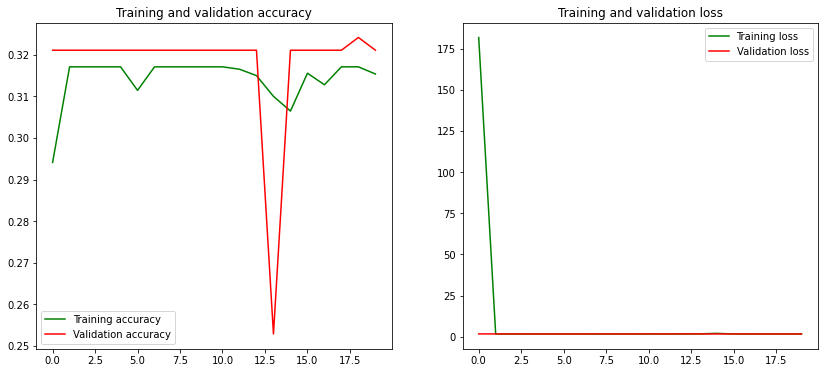

In [17]:
plot_accuracy_and_loss(training_4)

As we can see, the model almost overfit and that we get a really bad accuracy of 32% with a validation loss of 1.69

In [18]:
y_pred_4 = np.argmax(y_pred_4, axis=1)
y_test_4 = np.argmax(y_test, axis=1)

In [19]:
cm_4 = confusion_matrix(y_test_4, y_pred_4, labels= [0,1,2,3,4,5,6,7])


Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


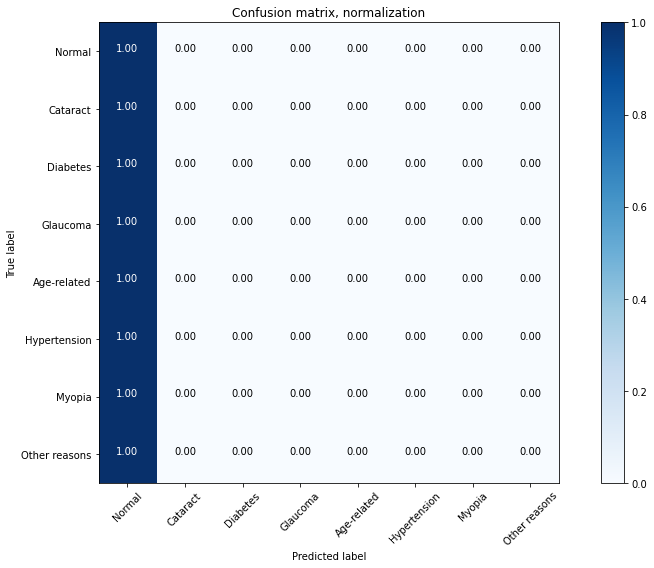

In [20]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm_4, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"], 
                      title='Confusion matrix, normalization')


The confusion matrix is reinforcing what we see with our accuracy which is that the model is pretty bad at detecting any of the diseases and cant even identify normal fundus images despite the dataset having most of images as Normal Fundus.

In [21]:
print(classification_report(y_test_4, y_pred_4, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"]))

accuracy_score(y_test_4, y_pred_4, normalize=True)

               precision    recall  f1-score   support

       Normal       0.32      1.00      0.48       414
     Cataract       0.00      0.00      0.00        62
     Diabetes       0.00      0.00      0.00       327
     Glaucoma       0.00      0.00      0.00        64
  Age-related       0.00      0.00      0.00        56
 Hypertension       0.00      0.00      0.00        45
       Myopia       0.00      0.00      0.00        37
Other reasons       0.00      0.00      0.00       300

     accuracy                           0.32      1305
    macro avg       0.04      0.12      0.06      1305
 weighted avg       0.10      0.32      0.15      1305



0.31724137931034485

We got only a 31% accuracy and can also see that the precision and recall was really bad for all the images. We will run the model for more epochs and changing the batch size to see if we can get a better accuracy but it might be a long shot since the model isn't great!

In [22]:
training_5 = model_4.fit(x=X_train, y=y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val))

2022-05-01 04:20:02.873097: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-05-01 04:20:04.524171: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.


Epoch 1/50
164/164 [==============================] - 74s 412ms/step - loss: 1.6891 - accuracy: 0.3160 - val_loss: 1.7088 - val_accuracy: 0.3211
Epoch 2/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6888 - accuracy: 0.3148 - val_loss: 1.7070 - val_accuracy: 0.3211
Epoch 3/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6896 - accuracy: 0.3151 - val_loss: 1.7106 - val_accuracy: 0.3211
Epoch 4/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6880 - accuracy: 0.3151 - val_loss: 1.7110 - val_accuracy: 0.3211
Epoch 5/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6884 - accuracy: 0.3160 - val_loss: 1.7120 - val_accuracy: 0.2529
Epoch 6/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6880 - accuracy: 0.3163 - val_loss: 1.7083 - val_accuracy: 0.3211
Epoch 7/50
164/164 [==============================] - 66s 403ms/step - loss: 1.6884 - accuracy: 0.3171 - val_loss: 1.7065 - val_ac

In [23]:
accuracy_5 = model_4.evaluate(X_test, y_test)
print(f"Validation loss: {accuracy_5[0]}")
print(f"Validation accuracy: {accuracy_5[1]}")
y_pred_5 = model_4.predict(X_test)
print(y_pred_5)

41/41 [==============================] - 3s 62ms/step - loss: 1.6963 - accuracy: 0.3172
Validation loss: 1.6962631940841675
Validation accuracy: 0.317241370677948
[[0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]
 [0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]
 [0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]
 ...
 [0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]
 [0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]
 [0.31776538 0.04231206 0.26105067 ... 0.02979698 0.03554088 0.23175061]]


Seems like the best accuracy we could achieve 31.7 which is same as before

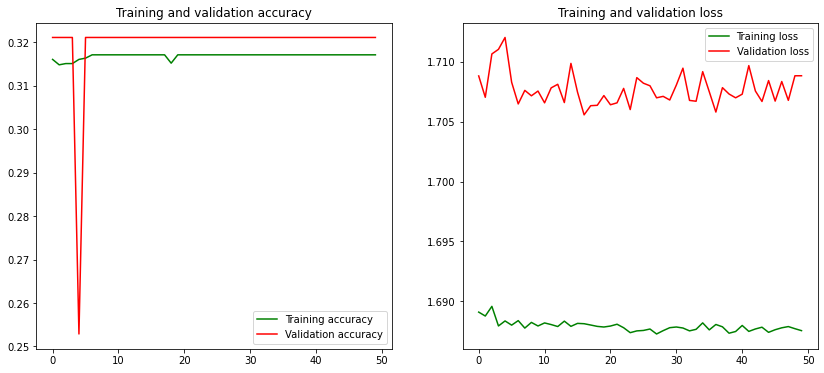

In [24]:
plot_accuracy_and_loss(training_5)

Our Validation accuracy fell steeply and then rose again and stayed consistent proving that the model didn't improve and we can see that the validation loss was higher than our training loss. Overall our model didn't improve.

In [25]:
y_pred_5 = np.argmax(y_pred_5, axis=1)
y_test_5 = np.argmax(y_test, axis=1)

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


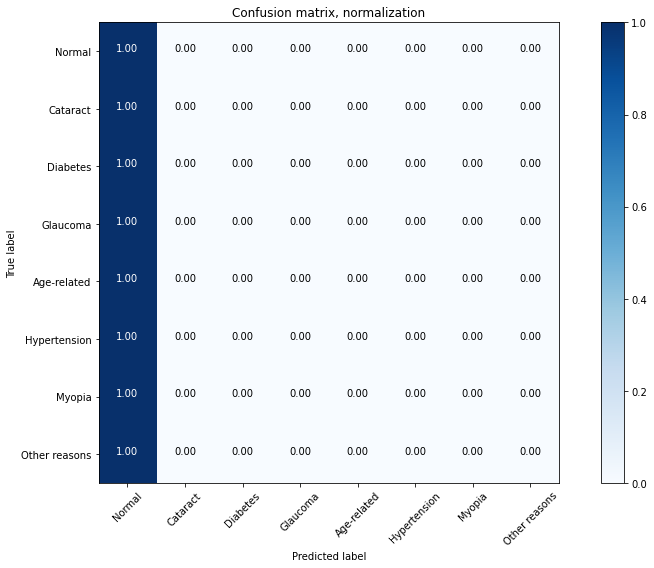

In [26]:
cm_5 = confusion_matrix(y_test_5, y_pred_5, labels= [0,1,2,3,4,5,6,7])

plt.figure(figsize=(12,8))
plot_confusion_matrix(cm_5, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"], 
                      title='Confusion matrix, normalization')


Confusion matrix again shows that the model didn't improve

In [27]:
print(classification_report(y_test_5, y_pred_5, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"]))

accuracy_score(y_test_5, y_pred_5, normalize=True)

               precision    recall  f1-score   support

       Normal       0.32      1.00      0.48       414
     Cataract       0.00      0.00      0.00        62
     Diabetes       0.00      0.00      0.00       327
     Glaucoma       0.00      0.00      0.00        64
  Age-related       0.00      0.00      0.00        56
 Hypertension       0.00      0.00      0.00        45
       Myopia       0.00      0.00      0.00        37
Other reasons       0.00      0.00      0.00       300

     accuracy                           0.32      1305
    macro avg       0.04      0.12      0.06      1305
 weighted avg       0.10      0.32      0.15      1305



0.31724137931034485

We can see that both the precision and recall have not changed for all the fundus images

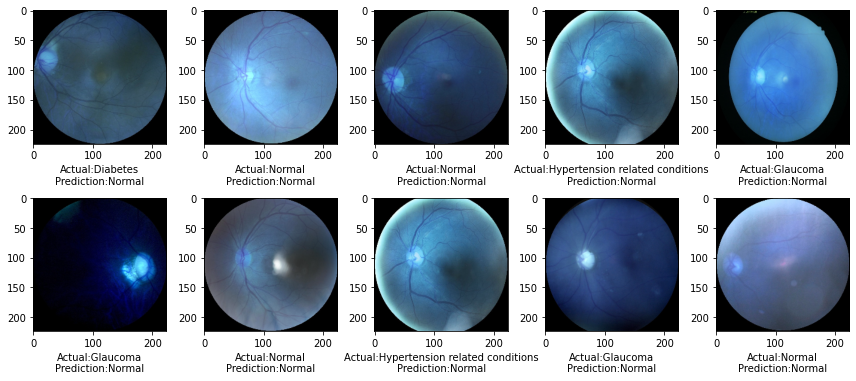

In [28]:
plt.figure(figsize=(12,10))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = y_test_5[sample]
    pred_category = y_pred_5[sample]
    
    if category == 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Age-related conditions"
    elif category == 5:
        label = "Hypertension related conditions"
    elif category == 6:
        label = "Myopia"
    elif category == 7:
        label = "Other reasons"
    
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1:
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Age-related conditions"
    elif pred_category == 5:
        pred_label = "Hypertension related conditions"
    elif pred_category == 6:
        pred_label = "Myopia"
    elif pred_category == 7:
        pred_label = "Other reasons"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

We can see that for a random set of images choosen for our test dataset, the model correctly predicted only 4/10 images

## Predicting using our model on completely new image loaded from system

In [29]:
# Loading in new image (the 5K resolution image)

new_image = cv.imread('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/2_right.jpg')
new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
new_image = cv.resize(new_image, (224,224))

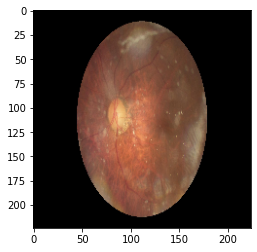

In [30]:
plt.imshow(new_image)

In [31]:
# Running model on new image

copy_new_image = np.array(new_image).reshape(-1,224,224,3)
new_prediction = model_4.predict(copy_new_image)
np = np.argmax(new_prediction, axis=1)


In [32]:
# Printing out prediction
np

array([0])

We can see that the image in the data set corresponds to Diabetes, but our model predicted it to be Normal 
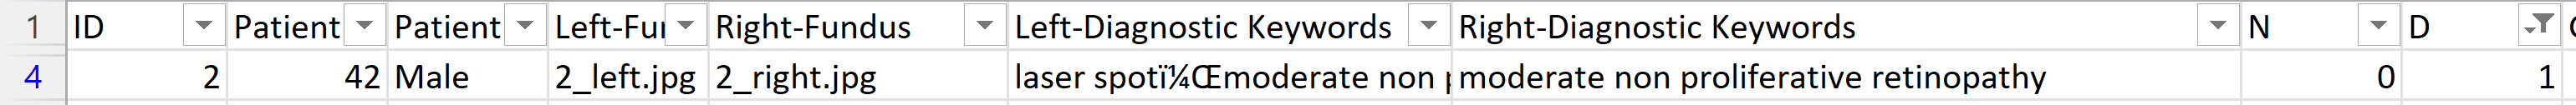